In [22]:
from clip import CLIP
from encoder import VAE_Encoder
from decoder import VAE_Decoder
from diffusion import Diffusion

import model_converter

def preload_models_from_standard_weights(ckpt_path, device):
    state_dict = model_converter.load_from_standard_weights(ckpt_path, device)

    encoder = VAE_Encoder().to(device)
    encoder.load_state_dict(state_dict['encoder'], strict=True)

    decoder = VAE_Decoder().to(device)
    decoder.load_state_dict(state_dict['decoder'], strict=True)

    diffusion = Diffusion().to(device)
    diffusion.load_state_dict(state_dict['diffusion'], strict=True)

    clip = CLIP().to(device)
    clip.load_state_dict(state_dict['clip'], strict=True)

    return {
        'clip': clip,
        'encoder': encoder,
        'decoder': decoder,
        'diffusion': diffusion,
    }

C:\Users\trail\AppData\Local\Temp\ipykernel_3572\1060814397.py:16: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  elif (torch.has_mps or torch.backends.mps.is_available()) and ALLOW_MPS:


Using device: cpu


100%|██████████| 50/50 [10:31<00:00, 12.62s/it]


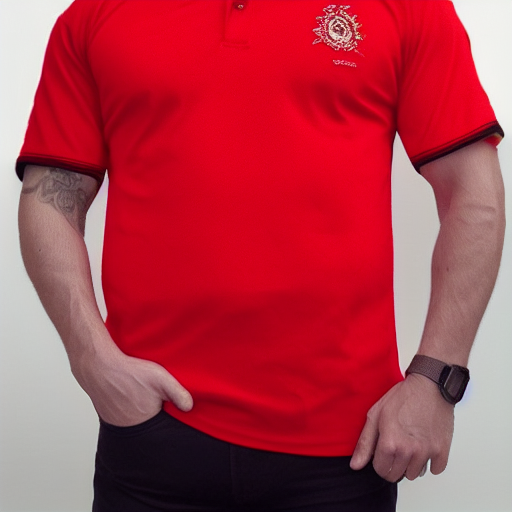

In [31]:
import torch
#import model_loader
import pipeline
from PIL import Image
from pathlib import Path
from transformers import CLIPTokenizer


DEVICE = "cpu"

ALLOW_CUDA = True
ALLOW_MPS = True

if torch.cuda.is_available() and ALLOW_CUDA:
    DEVICE = "cuda"
elif (torch.has_mps or torch.backends.mps.is_available()) and ALLOW_MPS:
    DEVICE = "mps"
print(f"Using device: {DEVICE}")

tokenizer = CLIPTokenizer("../data/vocab.json", merges_file="../data/merges.txt")
model_file = "../data/v1-5-pruned.ckpt"
models = preload_models_from_standard_weights(model_file, DEVICE)

## TEXT TO IMAGE

# prompt = "A dog with sunglasses, wearing comfy hat, looking at camera, highly detailed, ultra sharp, cinematic, 100mm lens, 8k resolution."
prompt = "A red shirt, highly detailed, ultra sharp, realistic."
uncond_prompt = ""  # Also known as negative prompt
do_cfg = True
cfg_scale = 8  # min: 1, max: 14

## IMAGE TO IMAGE

input_image = None
# Comment to disable image to image
#image_path = "../images/dog.jpg"
# input_image = Image.open(image_path)
# Higher values means more noise will be added to the input image, so the result will further from the input image.
# Lower values means less noise is added to the input image, so output will be closer to the input image.
strength = 0.9

## SAMPLER

sampler = "ddpm"
num_inference_steps = 50
seed = 42

output_image = pipeline.generate(
    prompt=prompt,
    uncond_prompt=uncond_prompt,
    input_image=input_image,
    strength=strength,
    do_cfg=do_cfg,
    cfg_scale=cfg_scale,
    sampler_name=sampler,
    n_inference_steps=num_inference_steps,
    seed=seed,
    models=models,
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer,
)

# Combine the input image and the output image into a single image.
Image.fromarray(output_image)